In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.integrate import odeint
from matplotlib.ticker import FormatStrFormatter

In [2]:
def RosenzweigMacArthurP(x, t, h2):
    c1 = 5.0
    h1 = 3.0
    c2 = 0.1
    m2 = 0.4
    m3 = 0.008
    
    dx = x[0]*(1-x[0]) - c1 * x[0] * x[1] / (1.0 + h1*x[0])
    dy = c1 * x[0] * x[1] / (1.0 + h1 * x[0]) - c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m2*x[1]
    dz = c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m3 * x[2]

    return (dx, dy, dz)

def RosenzweigMacArthur(x, t):
    c1 = 5.0
    h1 = 3.0
    c2 = 0.1
    m2 = 0.4
    m3 = 0.008
    h2 = 2.0
    
    dx = x[0]*(1-x[0]) - c1 * x[0] * x[1] / (1.0 + h1*x[0])
    dy = c1 * x[0] * x[1] / (1.0 + h1 * x[0]) - c2 * x[1] * x[2] / (1.0 + h2 * x[1]) - m2*x[1]
    dz = c2 * x[1] * x[2] / (1.0 + h2 * x[1]) - m3 * x[2]

    return (dx, dy, dz)

def Lorenz96P(x, t, F):
    N = 5 # dimension

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F(t)
    return d

def LorenzP(xi, t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma(t) * (y - x), x * (rho(t) - z) - y, x * y - beta(t) * z  # Derivatives


def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a(t) * y
    dz = b(t) + z * ( x - c(t) )

    return np.array( [dx,dy,dz] )

# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

In [3]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

"""
def delayEmbed(Xin, Yin,assignment,embInterval):
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    return (Xin, Yin)
"""

def delayEmbed(D, predHorizon, nLags, embInterval, t = None):
    
    totalRows = D.shape[0] + predHorizon + embInterval * nLags
    A = np.zeros((totalRows, 2 + nLags))
    
    A[:D.shape[0],0] = D.flatten()
    
    for i in range(1, 2 + nLags):
        lower = predHorizon + (i - 1) * embInterval
        upper = lower + D.shape[0]
        A[lower:upper, i] = D.flatten()
    
    rowsLost = predHorizon + nLags * embInterval
    if rowsLost != 0:
        B = A[rowsLost : -rowsLost]
    else: 
        B = A
    
    if t is None:
        return (B[:,1:], B[:,0, None])
    else:
        ty = t[predHorizon : predHorizon - rowsLost]
        tx = t[:-rowsLost]
        return (B[:,1:], B[:,0, None], tx, ty)

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

def FNNplot(Xr, l, st):
    dim = Xr.shape[1]
    # figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
    figFNN, axFNN = plt.subplots(dim, figsize=(16, 6*dim))
    # figFNN = plt.figure(figsize=(12, 8))
    # axFNN = figFNN.add_subplot()

    for d in range(dim):
        lyapExps = np.zeros(l+1)
        for s in range(1, st+1, 1):
            for i in range(l+1):
                Y, _ = delayEmbed(Xr[:,d,None], 0, i, s) # individual axis version
                # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
                # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
                lyapExps[i] = lyapunovExp(Y)

            if dim == 1:
                axFNN.plot(range(l+1), lyapExps, label="{e}".format(e=s))
            else:
                axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))

        if dim == 1:
            axFNN.legend()
            axFNN.set_xlabel("Embedding Dimension")
            # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
            axFNN.set_ylabel("Lyapunov Exponent")
        else:
            axFNN[d].legend()
            axFNN[d].set_xlabel("Embedding Dimension")
            # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
            axFNN[d].set_ylabel("Lyapunov Exponent")

    plt.show()

In [4]:
Test = np.array([1,2,3,4,5,6,7,8])
TestT = Test
# prediction stepsize, n Lags, interval
print(delayEmbed(Test, 2, 2, 1, t=TestT))

(array([[3., 2., 1.],
       [4., 3., 2.],
       [5., 4., 3.],
       [6., 5., 4.]]), array([[5.],
       [6.],
       [7.],
       [8.]]), array([1, 2, 3, 4]), array([3, 4, 5, 6]))


In [5]:
settlingTime = 0

end = 2**5
tlen = 2 ** 16 + settlingTime
reduction = 2 ** 8
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr[::reduction]

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.5])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9])
# t0 = np.ones(5)
# t0[0] += 0.1
t0 = np.array([0,5,15])

In [6]:
# Density Dependent Maturation
"""
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,0,None])
print(Xr.shape)
"""
"""
# Rosenzweig MacArthur
h2 = lambda t : 2.0 # - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,0,None]
# Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,:]

"""

rho = lambda t: 28 # + 16 * t / end # rho = 28.0
sigma = lambda t: 10 # + 8 * t / end # sigma = 10.0
beta = lambda t: 0.5 + 3 * t / end # beta = 8.0 / 3.0

states = odeint(LorenzP, t0, tr, args=(rho, sigma, beta))
Xr = standardize(states)[::reduction, 0, None]
print(Xr.shape, t.shape)
"""
gstates = standardize(odeint(RosenzweigMacArthur, np.array([0.8,0.1,9]), t*2))[:,1,None]
figG, axG = plt.subplots(1)
axG.plot(gstates)
plt.show()

# Lorenz 96
# F = lambda t : 7 + (2 ** 3) * t / end
# F = lambda t : 12 # + 5 * np.sin(2 * np.pi * t / end)
F = lambda t : 7 + 4 * gstates[np.array((tlen-100)*t/end,dtype=int)]

Xr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]
"""

# Rossler
"""
a = lambda t : 0.2 # + 0.2 * t / end
b = lambda t : 0.2 # + 1 * t / end
c = lambda t : 5.7 # + 5 * t / end
Xr = standardize(odeint(RosslerP, t0, t, args=(a,b,c)))[::reduction, 0, None]
"""

(256, 1) (256,)


'\na = lambda t : 0.2 # + 0.2 * t / end\nb = lambda t : 0.2 # + 1 * t / end\nc = lambda t : 5.7 # + 5 * t / end\nXr = standardize(odeint(RosslerP, t0, t, args=(a,b,c)))[::reduction, 0, None]\n'

In [7]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [8]:
""" UPDATE DRIVERS HERE """

digiDrivers = [beta]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
# gtsr = F(t) # driverArray
gtsr = beta(t)

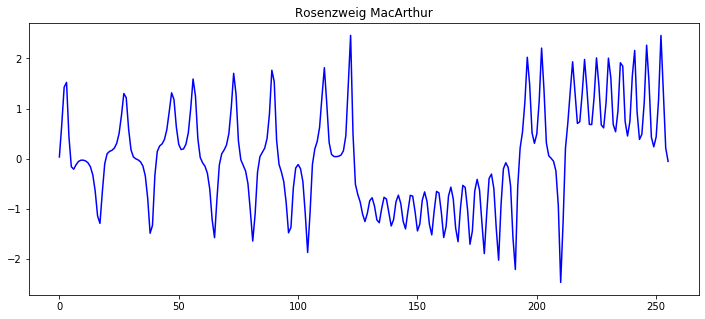

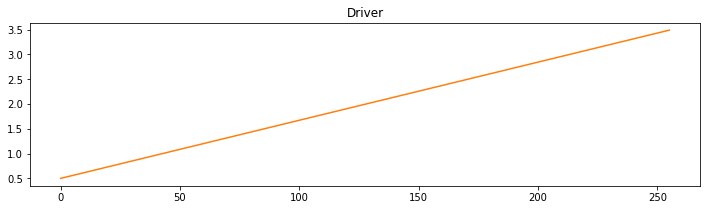

In [9]:
fig2 = plt.figure(2,figsize=(12,5))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

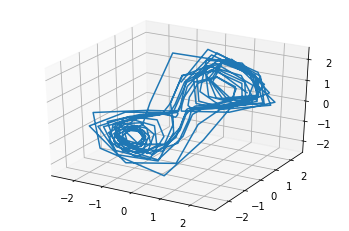

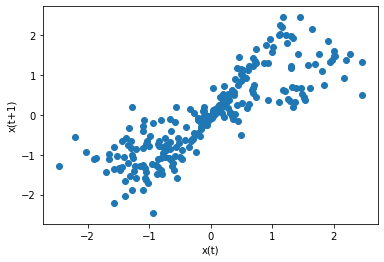

In [10]:
def threelagsfig(timeseries):
    eeee, yyyy = delayEmbed(timeseries, 0, 3, 1)
    figPP = plt.figure()
    axPP = figPP.gca(projection="3d")
    axPP.plot(eeee[:,0],eeee[:,1],eeee[:,2])
    plt.show()
    
def tandtplus1(timeseries):
    figTT, axTT = plt.subplots(1)
    axTT.scatter(timeseries[:-1], timeseries[1:])
    axTT.set_xlabel("x(t)")
    axTT.set_ylabel("x(t+1)")
    plt.show()
    
threelagsfig(Xr)
tandtplus1(Xr)

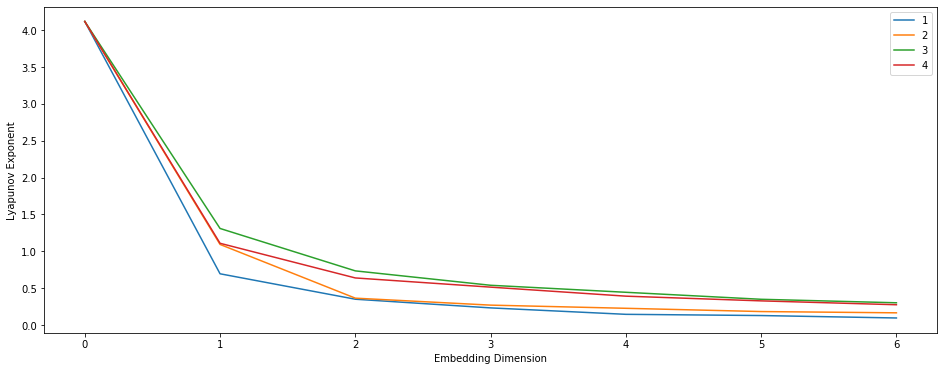

In [11]:
FNNplot(Xr, 6, 4)

In [12]:
X, Y, tx, ty = delayEmbed(Xr, 3, 6, 1, t=t)

"""
predictionStep = 1
X, t = delayEmbed(Xr,t,[6],1)

testTrainSplit = int(Xr.shape[0] * trainToTest)
Xtrain = X[:testTrainSplit]
Ytrain = Y[:testTrainSplit]
Xtest = X[testTrainSplit:]
Ytest = Y[testTrainSplit:]
"""

'\npredictionStep = 1\nX, t = delayEmbed(Xr,t,[6],1)\n\ntestTrainSplit = int(Xr.shape[0] * trainToTest)\nXtrain = X[:testTrainSplit]\nYtrain = Y[:testTrainSplit]\nXtest = X[testTrainSplit:]\nYtest = Y[testTrainSplit:]\n'

In [13]:
# SMap
"""
def nearestNeighbors(state, n):
    orderedNeighbors = sorted(range(len(trainStates)-1), key = lambda i : la.norm(state - trainStates[i]), reverse=False)
    return orderedNeighbors[:n]
"""
def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def nearestNeighborsPrediction(state):
    neighborIndexes = nearestNeighbors(state, numNeighbors)
    pred1neigh = list(map(lambda i: trainStates[i+1], neighborIndexes))
    return sum(pred1neigh) / numNeighbors

# make a 1 time step prediction based on a given state(nD vector)
def SMap(X, Y, x, theta):
    norms = la.norm(X-x,axis=1)
    d = np.mean(norms) # d = np.mean(norms) # 
    
    W = np.exp(-1 * theta * norms / d)
    # print(X.shape, np.diag(W).shape, Y.shape)
    H = la.inv(np.transpose(X) @ np.diag(W) @ X) @ np.transpose(X) @ np.diag(W) @ Y
    return x @ H

def getWeightedValues(state, states, theta, d):
    # calculate weights for each element
    return np.exp(-1 * theta * la.norm(states-state,axis=1) / d)
    """
    weights = np.zeros(states.shape[0])
    current = np.array(state)
    for i, elem in enumerate(states):
        diff = current - elem
        norm = la.norm(diff)
        exponent = -1 * theta * norm / d
        weights[i] = np.exp(exponent)
    return weights
    """

def isInvertible(M):
    return M.shape[0] == M.shape[1] and la.matrix_rank(M) == M.shape[0]
    
def calculateD(states):
    return np.mean(np.fromfunction(lambda i,j: la.norm(states[i]-states[j]),(states.shape[1],states.shape[1]),dtype=int))

def GMap(X, Y, T, x, t, theta, delta, return_hat=False):
    
    # include time as a state variable, scaled by delta
    T = T.reshape((T.shape[0],1))
    if (delta > 0):
        M = np.hstack([np.ones(T.shape), X, T*delta])
        xaug = np.hstack([1, x, t * delta])
        # M = np.hstack([X, T*delta])
        # xaug = np.hstack([x, t * delta])
    else:
        # print(np.ones(T.shape).shape, X.shape)
        M = np.hstack([np.ones(T.shape), X])
        xaug = np.hstack([1, x])
        # M = X
        # xaug = x
    xaug = np.reshape(xaug, (1,xaug.shape[0]))
    
    norms = la.norm(M - xaug,axis=1)
   
    # create weights
    d = np.mean(norms)
    weights = np.exp(-1*theta*norms/d)
    W = np.diag(np.sqrt(weights))
    # W = np.diag(weights)
    weights = np.reshape(weights,(weights.shape[0],1))
    
    # print(X, Y, T, x, t)
    
    if (isInvertible(M)):
        hat = xaug @ la.inv((W@M).T @ (W@M)) @ (W@M).T @ W
        # params = la.inv((W@M).T @ (W@M)) @ (W@M).T @ (W@Y)
    else:
        hat = xaug @ la.pinv((W@M).T @ (W@M)) @ (W@M).T @ W
        # U, E, V = la.svd(W @ M, full_matrices=False)
        # hat = xaug @ V.T @ np.diag(np.power(E,-1,where=(E!=0))) @ U.T @ W
        # hat = xaug @ V.T @ np.diag(1/(E+1e-10)) @ U.T @ W
        # params = V.T @ np.diag(1/(E+1e-10)) @ (U.T @ W @ Y)[:E.shape[0]]
    # prediction = xaug @ params
    prediction = hat @ Y
    
    if return_hat:
        return (prediction, hat)
    else:
        return prediction
    

In [15]:
A = np.array([2,3,0],dtype=float)
print(np.power(A, -1, where=(A!=0)))

C = np.array([1,2,1])
D = np.array([[1,2,1],[1,2,2],[-1,2,3]])

[ 0.5         0.33333333 14.25      ]


In [16]:
def GMapOptimize(X, Y, tx, ty, thetaVals, deltaVals, calc_hat=False):
    predictedTimeSeries = np.zeros((nTrials, 1))
    trueTimeSeries = np.zeros(nTrials)

    errThetaDelta = np.ones((thetaVals.shape[0], deltaVals.shape[0]))

    lowestError = float('inf')

    thetaBest = 0
    deltaBest = 0
    lowestError = float('inf')
    lowestVariance = 0
    for deltaexp in range(deltaVals.shape[0]):
        for thetaexp in range(thetaVals.shape[0]):
            theta = thetaVals[thetaexp]
            delta = deltaVals[deltaexp]
            
            # timestepPredictions = predictionHorizon(X, Y, t, theta, delta, predHorizon, nTrials)
            if calc_hat:
                timestepPredictions, hat = leaveOneOut(X, Y, tx, ty, theta, delta, True)
            else:
                timestepPredictions = leaveOneOut(X, Y, tx, ty, theta, delta)
            
            totalError = np.sum((timestepPredictions - Y)**2)
            if totalError < lowestError:
                lowestError = totalError
                deltaBest = delta
                thetaBest = theta
                lowestVariance = np.var(timestepPredictions)
            
            errThetaDelta[thetaexp, deltaexp] = totalError
            # print(f"Theta = {theta} Delta = {delta} Error = {errThetaDeltaGMap[thetaexp, deltaexp]}")
    
    if (calc_hat):
        return (thetaBest, deltaBest, errThetaDelta, hat)
    else:
        return (thetaBest, deltaBest, errThetaDelta)

# The training set is all before the training set
def predictionHorizon(X, Y, t, theta, delta, predHorizon, nTrials):
    
    timestepPredictions = np.zeros((nTrials, 1))
    
    for i in range(nTrials):
        # j is prediction stepsize
        # Xj and Yj are X and Y with j step prediction
        Xj = X[:-predHorizon]
        Yj = Y[predHorizon:]
        tXj = t[:-predHorizon]
        tYj = t[predHorizon:]

        # this is the cutoff between training and testing data
        startIndex = Xj.shape[0] - i - predHorizon

        # create the train and test stuff
        Xjtr = Xj[:startIndex]
        Yjtr = Yj[:startIndex]
        tXjtr = tXj[:startIndex]
        tYjtr = tYj[:startIndex]

        Xjts = Xj[startIndex]
        Yjts = Yj[startIndex]
        tXjts = tYj[startIndex]
        tYjts = tYj[startIndex]

        prediction = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

        # predictedTimeSeries[i] = prediction
        # trueTimeSeries[i] = Yjts

        # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
        # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

        timestepPredictions[i] = (prediction - Yjts)
            
    return timestepPredictions

# leaves one input and output pair out, and use rest as training data
def leaveOneOut(X, Y, tx, ty, theta, delta, get_hat=False):
    
    if get_hat:
        hat = np.zeros((X.shape[0]-1,X.shape[0]-1))
    timestepPredictions = np.zeros((X.shape[0], 1))
    
    for i in range(0,X.shape[0]-1):
        # create the train and test stuff
        Xjts = X[i]
        Yjts = Y[i]
        tXjts = tx[i]
        tYjts = ty[i]

        Xjtr = np.delete(X, i, axis=0)
        Yjtr = np.delete(Y, i, axis=0)
        tXjtr = np.delete(tx, i, axis=0)
        tYjtr = np.delete(ty, i, axis=0)

        if get_hat:
            prediction, hat_vector = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta, return_hat=True)
            hat[i,:] = hat_vector
        else:
            # GMap(X, Y, T, x, t, theta, delta, return_hat=False)
            prediction = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta, return_hat=False)

        timestepPredictions[i] = prediction
            
    if get_hat:
        return (timestepPredictions, hat)
    else:
        return timestepPredictions

def GMapMinError(X, t, predHorizon, thetaVals, deltaVals, nTrials):
    # X, te = delayEmbed(Xr, t, [embdim],1)
    Y = X[:,0]

    timestepPredictions = np.zeros((nTrials, 1))

    predictedTimeSeries = np.zeros((nTrials, 1))
    trueTimeSeries = np.zeros(nTrials)

    errThetaDelta = np.ones((thetaVals.shape[0], deltaVals.shape[0]))

    lowestError = float('inf')

    thetaBest = 0
    deltaBest = 0
    lowestError = float('inf')
    lowestVariance = 0
    for deltaexp in range(deltaVals.shape[0]):
        for thetaexp in range(thetaVals.shape[0]):
            theta = thetaVals[thetaexp]
            delta = deltaVals[deltaexp]
            for i in range(nTrials):
                # j is prediction stepsize
                # Xj and Yj are X and Y with j step prediction
                Xj = X[:-predHorizon]
                Yj = Y[predHorizon:]
                tXj = t[:-predHorizon]
                tYj = t[predHorizon:]

                # this is the cutoff between training and testing data
                startIndex = Xj.shape[0] - i - predHorizon

                # create the train and test stuff
                Xjtr = Xj[:startIndex]
                Yjtr = Yj[:startIndex]
                tXjtr = tXj[:startIndex]
                tYjtr = tYj[:startIndex]

                Xjts = Xj[startIndex]
                Yjts = Yj[startIndex]
                tXjts = tYj[startIndex]
                tYjts = tYj[startIndex]
                
                # print(Xjtr.shape, Yjtr.shape, tXjtr.shape, Xjts.shape, tXjts.shape)
                prediction = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

                predictedTimeSeries[i] = prediction
                trueTimeSeries[i] = Yjts

                # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
                # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

                timestepPredictions[i] = abs(prediction - Yjts)

            totalError = np.sum(timestepPredictions**2)
            if totalError < lowestError:
                lowestError = totalError
                deltaBest = delta
                thetaBest = theta
                lowestVariance = np.var(timestepPredictions)
            errThetaDelta[thetaexp, deltaexp] = totalError
            # print(f"Theta = {theta} Delta = {delta} Error = {errThetaDeltaGMap[thetaexp, deltaexp]}")
    
    return (lowestError, lowestVariance)

In [17]:
def likelihoodRatioTest(X, t, predHorizon, thetaVals, deltaVals):
    nTrials = int(X.shape[0] / 4)
    
    assert deltaVals[0] == 0
    
    thetaBest, deltaBest, errThetaDelta, hat = GMapOptimize(X, t, predHorizon, thetaVals, deltaVals, nTrials, calc_hat=True)
    print(f"SMAP ERROR: {np.min(errThetaDelta[:,0])} \n GMAP ERROR: {np.min(errThetaDelta)}")
    
    dof = np.trace(hat)
    
    return (X.shape[0] * np.log(np.min(errThetaDelta[:,0]) / np.min(errThetaDelta)), dof)
    
    # errS, varS = GMapMinError(X, t, predHorizon, thetaVals, np.array([0]), nTrials)
    # errG, varG = GMapMinError(X, t, predHorizon, thetaVals, deltaVals, nTrials)
    
    # return (errS / varS) - (errG / varG)

# WRONG, NEED TO USE APPROPRIATE HAT MATRIX, WHICH IS MADE OF 
def dofestimation(X):
    return np.trace(X @ la.inv(X.T @ X) @ X.T)

In [20]:
thetatmp, deltatmp = (10, 0)
predictedTS = leaveOneOut(X, Y, tx, ty, thetatmp, deltatmp)
prediction = GMap(X[:-1], Y[:-1], tx[:-1], X[-1],tx[-1], thetatmp, deltatmp)
# print(predictedTS)
print(prediction, Y[-1])
print(predictedTS[-1])

[[-0.0199437]] [-0.05465173]
[0.]


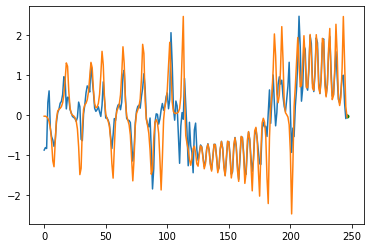

In [21]:
figLOU, axLOU = plt.subplots()
axLOU.plot(predictedTS)
axLOU.plot(Y)
axLOU.scatter(tx[-1]*tlen/(end*reduction), prediction, marker=".", c='green')
plt.show()

In [ ]:
print(X.shape, t.shape)

In [ ]:
nHPvals = 10
predHorizon = 6
nTrials = int(Xr.shape[0] / 3)

thetaVals = np.linspace(1, 100, num=nHPvals)
deltaVals = np.linspace(0, 2, num=nHPvals)

thetaBest, deltaBest, errThetaDeltaGMap, hatG = GMapOptimize(X, Y, tx, ty, thetaVals, deltaVals, True)
thetaBestS, _ , errThetaSMap, hatS = GMapOptimize(X, Y, tx, ty, thetaVals, np.array([[0]]), True)

print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

In [ ]:
print(np.trace(hatG))

In [ ]:
# Theta Optimization
fig1, ax1 = plt.subplots(1, figsize = (8,3))
ax1.plot(thetaVals, errThetaSMap, c="silver")
ax1.set_title("SMap Error Results")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Error")

fig2, ax2 = plt.subplots(1, figsize = (16,16))
plt.colorbar(ax2.imshow(np.log(errThetaDeltaGMap)))
ax2.set_xticks(range(nHPvals))
ax2.set_xticklabels(list(np.round(deltaVals,2)))
ax2.set_xlabel("Delta")
ax2.set_yticks(np.arange(nHPvals))
ax2.set_yticklabels(list(np.round(thetaVals,2)))
ax2.set_ylabel("Theta")
ax2.set_title("GMap Error Results")
plt.show()

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

In [ ]:
print(f"DOF = {np.trace(hatG)}")

In [ ]:

# n Timesteps 
maxPredictionHorizon = 7
nTrials = 30

timestepPredictionsGMap = np.zeros((nTrials, maxPredictionHorizon))
timestepPredictionsSMap = np.zeros((nTrials, maxPredictionHorizon))

GMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
SMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
TrueTimeSeries = np.zeros(nTrials)

for j in range(1,maxPredictionHorizon+1):    
    # HP optimize, expensive :(
    thetaBestS, _ , _ = GMapOptimize(X, Y, tx, ty, thetaVals, np.array([[0]]), False)
    thetaBest, deltaBest, _ = GMapOptimize(X, Y, tx, ty, thetaVals, deltaVals, False)
    for i in range(nTrials):
        # j is prediction stepsize
        # Xj and Yj are X and Y with j step prediction
        Xj = X[:-j]
        Yj = Y[j:]
        tXj = t[:-j]
        tYj = t[j:]

        # this is the cutoff between training and testing data
        startIndex = Xj.shape[0] - i - maxPredictionHorizon

        # create the train and test stuff
        Xjtr = Xj[:startIndex]
        Yjtr = Yj[:startIndex]
        tXjtr = tXj[:startIndex]
        tYjtr = tYj[:startIndex]

        Xjts = Xj[startIndex]
        Yjts = Yj[startIndex]
        tXjts = tYj[startIndex]
        tYjts = tYj[startIndex]

        TrueTimeSeries[i] = Yjts
        
        predictionSMap = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, thetaBestS, 0)
        predictionGMap = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, thetaBest, deltaBest)

        SMapPredictedTimeSeries[i,j-1] = predictionSMap
        GMapPredictedTimeSeries[i,j-1] = predictionGMap

        timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)
        timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)


In [ ]:
""""""
figTS, axTS = plt.subplots(3, figsize=(12,10))
axTS[0].boxplot(timestepPredictionsGMap)
axTS[0].set_title("GMap")
axTS[0].set_ylabel("Error")
axTS[0].set_xlabel("Steps Out")
axTS[1].boxplot(timestepPredictionsSMap)
axTS[1].set_title("SMap")
axTS[1].set_ylabel("Error")
axTS[1].set_xlabel("Steps Out")
axTS[2].set_title("GMap Pred vs SMap Pred vs TRUTH")
axTS[2].plot(SMapPredictedTimeSeries, c="silver")
axTS[2].plot(GMapPredictedTimeSeries, c="green")
axTS[2].plot(TrueTimeSeries, c="blue")
    
figD, axD = plt.subplots(1)
axD.set_xticks(np.arange(1,maxPredictionHorizon+1))
axD.plot(np.arange(1,maxPredictionHorizon+1), np.mean(timestepPredictionsSMap,axis=0) / np.mean(timestepPredictionsGMap, axis=0))
axD.set_title("Improvement of GMap compared to SMap")
axD.set_xlabel("Number of steps out")
axD.set_ylabel("Err SMap / Err GMap")
    
plt.tight_layout()
plt.show()

In [ ]:
for i in range(1,6+1):
    lambdaLR, dof = likelihoodRatioTest(X,t,i, thetaVals, deltaVals)
    print(f"LRT Score w/ {i} steps = {lambdaLR}, DOF = {dof}")

In [ ]:
"""
Note: just got the result that GMap improves predictablility in the case of a Lorenz system at from between
1 to 4 and 7+ steps ahead, which is counterintuitive. It should be that in the low step case, little
nonstationary signal is going to effect the results, so SMap will do better, while at the extrema, GMap
will likely overextrapolate. But it seems that GMap is doing better in the near and longer term without regard
for the intermediate. Strange.

Also the time series should be moderately smooth for this to have any hope of working
"""